In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
import json
import fiona

# clustering techneques 
import tslearn
from tslearn.clustering import TimeSeriesKMeans

# sklearn clustering (list of those to test)
from sklearn.cluster import KMeans # DBSCAN, # AgglomerativeClustering, Birch, OPTICS 
from sklearn.cluster import MeanShift

# tif file creation
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import re

In [ ]:
pth = "data/"

# collect paths for all csv files in the folder
paths = []

for root, dirs, files in os.walk(pth):
    for file in files:
        if file.endswith(".csv"):
            paths.append(os.path.join(root, file))

print(f"Found {len(paths)} CSV files.")

In [ ]:
def prep_data(dir):
    """Creates two dataframes from a CSV file, one ready for clustering with additional columns removed and the other with all columns left intact."""
    df1 = pd.read_csv(dir)
    df1 = df1.dropna()
    df2_clear = df1.copy()
    df2_clear = df2_clear.drop(columns=["system:index", ".geo"])
    df2_clear = df2_clear.set_index("file_name")
    df1 = df1.set_index("file_name")
    df2_clear = df2_clear.apply(pd.to_numeric, errors='coerce')

    return df1, df2_clear

In [ ]:
def extract_band_time_series_array(df):
    """
    Convert a DataFrame with 'month_band' columns (e.g., '0_B1') into a 2D NumPy array
    of shape (n_bands, 12), where each row is a time series (12 months) for one band.
    
    Assumes input DataFrame contains clean data in a {month_index}_{band_name} format and nothing else! 
    """
    col_names = df.columns.tolist()
    
    # Extract unique bands and months
    bands = sorted(set(name.split('_')[1] for name in col_names if '_' in name))
    months = sorted(set(int(name.split('_')[0]) for name in col_names if '_' in name))

    print("Bands:", bands)
    print("Months:", months)

    df_final = df.copy()
    # add empty column 
    df_final['ts_matrix'] = None

    for row in df.index:
        row_df = df.loc[[row]]
        arr_bands = np.zeros((len(bands), len(months)))
        
        # Extract the time series for each band
        for band in bands:
            # temp_df = df.filter(like=f"_{band}")
            temp_df = row_df.filter(regex=fr"_{band}$")
            for month in months:
                col_name = f"{month}_{band}"
                if col_name in temp_df.columns:
                    arr_bands[bands.index(band), months.index(month)] = temp_df[col_name].values[0]
                else:
                    arr_bands[bands.index(band), months.index(month)] = np.nan
                    print(f"Column {col_name} not found in temp_df, setting to NaN")

        # save bkac into origina 
        df_final.at[row, 'ts_matrix'] = arr_bands
        
    return df_final

In [ ]:
def disp_labels(df, labels, output_img="plt.png", output_tif="plt.tif", UTM_EPSG="EPSG:32638", EPSG="EPSG:4326", FLAG_SHOW=True):
    # GeoDataFrame creation
    gdf = gpd.GeoDataFrame({
        "clusters": labels,
        "geometry": df[".geo"].apply(lambda x: shape(json.loads(x)))
    }, crs="EPSG:4326")
    gdf = gdf.to_crs(UTM_EPSG) # for some reason does not work at ESPG:4326 instead need ot use UTM_EPSG for Iraq 

    # Plot
    fig, ax = plt.subplots(figsize=(30, 30), dpi=300)
    gdf.plot(column="clusters", ax=ax, cmap="tab10", edgecolor="none", linewidth=0, antialiased=False)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(output_img, dpi=600)

    if FLAG_SHOW:
        plt.show()
    else:
        plt.close()

In [ ]:
# pth = "F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/pts_merge_test3.csv"

# df1 = pd.read_csv(pth)
# df1 = df1.dropna()

# df2_clear = df1.copy()
# df2_clear = df2_clear.drop(columns=["system:index", ".geo"])

# # file_name becomes the index
# df2_clear = df2_clear.set_index("file_name")
# df1 = df1.set_index("file_name")

# # convert rest to numeric
# df2_clear = df2_clear.apply(pd.to_numeric, errors='coerce')

# df2_clear.head()

In [ ]:
# from sklearn.cluster import KMeans

# # cluster the data
# kmeans = KMeans(n_clusters=20, random_state=42)
# kmeans.fit(df_raw.copy())

# df_raw.head()

In [ ]:
# for path in paths:
#     file_name = os.path.basename(path)
#     output_img = f"tests_10-07/{file_name.replace('.csv', '')}"
#     output_tif = f"tests_10-07/{file_name.replace('.csv', '')}"

#     random_state = 42  # reproducibility as this is a test run 

    
#     df = pd.read_csv(path)
#     df = df.dropna()
#     df_raw = df.copy()
#     df_raw = df_raw.drop(columns=["system:index", ".geo"])
#     df_raw = df_raw.set_index("file_name")
#     df = df.set_index("file_name")
#     df_raw = df_raw.apply(pd.to_numeric, errors='coerce')

#     print(f"Processing {file_name}...")
#     print(f"Output image: {output_img}_k(k).png")

#     # sklearn kmeans clustering
#     for k in [10, 15, 20, 25, 30, 40, 50]:
#         kmeans = KMeans(n_clusters=k, random_state=random_state)
#         kmeans.fit(df_raw)

#         # disp_labels(df, kmeans.labels_, output_img=f"{output_img}_k{k}.png", output_tif=f"{output_tif}_k{k}.tif")
#         disp_labels(df, kmeans.labels_, output_img=f"{output_img}_k{k}.png", output_tif=f"{output_tif}_k{k}.tif")

#     # DBSCAN clustering skipped due to never producing anything of value in this case

In [98]:
def os_path_chcker(output_dir, postfix=".tif", NAME_CODE_LIM=8, FLAG_APPEND_POSTFIX=True):
    """
        Ensures that the output directory is valid, exists and can be written to.

        This is a simple function that does three things:
            1. Checks if the directory exists, if not creates it.
            2. Checks if the file name is valid (and not empty, else creates a unique filename).
            3. (Optional) Appends a postfix to the file name if it does not already end with it.

    Args:
        output_dir (str): The directory path to check.
        postfix (str, optional): The postfix to append to the file name if it does not already end with it. Default is ".tif".
        NAME_CODE_LIM (int, optional): The length of the hex code to generate for filename. Default is 8.
        FLAG_APPEND_POSTFIX (bool, optional): Whether to append the postfix if the file name does not end with it. Default is True.
    """


    # path existance check
    if not os.path.exists(os.path.dirname(output_dir)):
        os.makedirs(os.path.dirname(output_dir))
        print(f"Created directory: {os.path.dirname(output_dir)}")


    # file name existance check
    flag_filename = not os.path.basename(output_dir)
    while flag_filename:
        print("Generating new file name...")
        # assign unique name to the tif file
        new_file_name = f"{os.urandom(NAME_CODE_LIM).hex()}{postfix}"
        if not os.path.exists(output_dir + new_file_name):
            output_dir += new_file_name
            flag_filename = False
            print(f"New File Name: {output_dir}")


    # check labelled correctly 
    if FLAG_APPEND_POSTFIX and not output_dir.endswith(postfix):
        print(f"Output directory {output_dir} does not end with .tif, appending .tif")
        output_dir += {postfix}
        
    return output_dir


def export_to_tif(df, bands, output_dir, res=50, UTM_ESPG=32638, EPSG=4326):
    """
        Exports a DataFrame generated by PlotToSat to a GeoTIFF file. 

        Note: df files MUST CONTAIN:
        - `.geo` column with GeoJSON geometries.
        - `file_name` column with unique identifiers for each row.
        - 1 Unique band labelled in `bands` list - this CAN BE LABELLED CLUSTERS. 

        Expected formats:
            Time-Series data should be in a DataFrame with 'month_band' columns (e.g., '0_B1', '1_B2', etc.).
            if a band is provideda e.g.m B1 but there are no pre-fix values this data will be assumed to be a single band AS-IS, and will be included in the output just as that band alone. 

        Args:
            df (pd.DataFrame): PlotToSat Style pandas DataFrame containing time-series data or single band data. Must have file_name and `.geo` geometry columns.
            bands (list): List of band names to include in the output. e.g., ['B1', 'B2', 'B3'] or ['SingleBand', etc.] can be mixed with single band data.
            output_dir (str): Output file directory for the GeoTIFF.
            res (int, optional): Resolution of the output raster in meters. Default is 50m.
            UTM_ESPG (int, optional): EPSG code for the UTM coordinate reference system. Default is 32638.
            


            # EPSG (int, optional): EPSG code for the coordinate reference system.
    """

    # Ensure output directory is valid, exists and can be written to.
    file = os_path_chcker(output_dir, postfix=".tif", NAME_CODE_LIM=8, FLAG_APPEND_POSTFIX=True)


    # Sort the Bands into single and time-series band data. 
    column_heads = df.columns.tolist()

    
    # all available bands in the data
    band_columns = [col for col in column_heads if any(col.endswith(band) for band in bands)]


    # Acceptable bands to process 
    acceptable_lst = []
    for col in bands:
        if any(col.startswith(f"{i}_") for i in range(12)):
            # must be non-prefix and only one band of that ts 
            if col not in acceptable_lst and any(coli for coli in band_columns if coli == col):
                acceptable_lst.append(col)
            # acceptable_lst.append(col)
        else:
            # must exist in band_columns and take all 
            appended = False
            for i in range(12):
                if any(coli for coli in band_columns if coli == f"{i}_{col}"):
                    if f"{i}_{col}" not in acceptable_lst:
                        # add only if not already in list     
                        acceptable_lst.append(f"{i}_{col}")
                        appended = True

            if appended == False:
                # if not appended must be a unique column 
                acceptable_lst.append(col)
    
    band_columns = acceptable_lst

 
    geometry = df[".geo"].apply(lambda x: shape(json.loads(x)))
    gdf = gpd.GeoDataFrame(df[band_columns].copy(), geometry=geometry, crs=f"EPSG:{EPSG}") # EPSG not UTM_ESPG else will raise an error

    gdf_utm = gdf.to_crs(epsg=UTM_ESPG)

    minx, miny, maxx, maxy = gdf_utm.total_bounds
    width = int((maxx - minx) / res)
    height = int((maxy - miny) / res)

    transform = from_origin(minx, maxy, res, res)

    if width <= 0 or height <= 0:
        raise ValueError(f"Invalid raster dimensions (width={width}, height={height}). Check CRS and resolution.")

    # Build Raster Stack
    rasters = []
    for band in band_columns:
        values = gdf_utm[band]
        shapes = ((geom, val) for geom, val in zip(gdf_utm.geometry, values))
        raster = rasterize(
            shapes=shapes,
            out_shape=(height, width),
            transform=transform,
            dtype="float32",
            fill=np.NaN,  # Fill with NaN values for NO FUCKING DATA
        )

        rasters.append(raster)

    raster_stack = raster_stack = np.stack(rasters, axis=0) if len(rasters) >= 2 else rasters

    # Save rasters to GeoTIFF 
    with rasterio.open(
        file,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=len(band_columns),
        dtype="float32",
        crs=f"EPSG:{UTM_ESPG}",
        transform=transform,
        nodata=np.NaN,  # Set NoData value to NaN
    ) as dst:
        for i, band in enumerate(band_columns):
            dst.write(raster_stack[i], i + 1)
            dst.set_band_description(i + 1, band) # Keep band discription!!!

In [ ]:
# df_bands_ts = df1.filter(regex=r"^\d+_(B\d+)$")

# df_bands_ts.head()

In [ ]:
# # Test Files sklearn kmeans is fast, not the best but fast. 

# # Simple small subregion for testing 
# pth = "F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/pts_merge_test1.csv"

# # Prepare the DataFrames (raw = to be used in clustering, df = for plotting)
# df1 = pd.read_csv(pth)
# df1 = df1.dropna()
# df2_clear = df1.copy()
# df2_clear = df2_clear.drop(columns=["system:index", ".geo"])
# df2_clear = df2_clear.set_index("file_name")
# df1 = df1.set_index("file_name")
# df2_clear = df2_clear.apply(pd.to_numeric, errors='coerce')
# # df_raw.head()

# kmeans = KMeans(n_clusters=20, random_state=42)
# kmeans.fit(df2_clear.copy())

# # index of file_name, .geo and labels
# df_final = pd.DataFrame({
#     "file_name": df1.index,
#     ".geo": df1[".geo"],
#     "cluster": kmeans.labels_
# })
# df_final = df_final.set_index("file_name")

# df_final.head()

# # Create GeoTIFF
# # export_to_tif(df_final, ["cluster"], "_test/", res=50, EPSG=4326)

# # TIF TEST
# export_to_tif(df1, ['0_B4', '0_B3', '0_B2'], "_test/")


# # TIF TEST 2 
# export_to_tif(df_final, ["cluster"], "_test/test.tif", res=50, EPSG=4326)

In [ ]:
def clip(polygon, df, UTM_ESPG=32638, EPSG=4326):
    """
        Clips the DataFrame based on the .geo column and a given polygon.   
    
    Args:
        polygon (shapely.geometry.Polygon): The polygon to clip the DataFrame to.
        df (pd.DataFrame): The DataFrame containing the geometries to be clipped.
        
    Returns:
        pd.DataFrame: The clipped DataFrame.
    """

    # based on .geo column drop all rows that do not intersect with the polygon
    df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=UTM_ESPG)
    gdf = gdf[gdf.geometry.within(polygon)]
    gdf = gdf.drop(columns=['geometry'])

    # convert back to DataFrame
    df_clipped = pd.DataFrame(gdf)

    return df_clipped

# # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# import fiona
# with fiona.open("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/data/test_zone1.geojson") as src:
#     feature = next(iter(src))
#     zone_polygon = shape(feature['geometry'])
# # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# df_clipped = clip(zone_polygon, df1)
# df_clipped.head()

In [106]:
def load_zones(dir):
    """
        Loads in polygons zones from a directory containing GeoJSON files.
    """

    files = []

    if dir is not [] and os.path.isfile(dir) and dir.endswith('.geojson'):
        files = [dir]
    else: 
        files = [f for f in os.listdir(dir) if f.endswith('.geojson')]
    polygons = []

    for file in files:
        with fiona.open(os.path.join(dir, file)) as src:
            for feature in src:
                polygons.append(shape(feature['geometry']))

    return polygons    

zones = load_zones("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/zones")

In [69]:
def clip_to_polygon(polygon, df, utm_epsg=32638, wgs_epsg=4326):
    """
    Clips the input DataFrame to rows whose `.geo` geometry intersects the given polygon.

    Args:
        polygon (shapely.geometry.Polygon): The polygon to clip to.
        df (pd.DataFrame): DataFrame with a '.geo' column (GeoJSON format).
        utm_epsg (int): EPSG code of the UTM projection used for filtering.
        wgs_epsg (int): EPSG code of the incoming geometry (usually EPSG:4326).

    Returns:
        pd.DataFrame: Subset of df with geometries intersecting the polygon.
    """
    # Reproject the polygon to UTM
    polygon_proj = gpd.GeoSeries([polygon], crs=f"EPSG:{utm_epsg}").to_crs(epsg=utm_epsg).iloc[0]

    # Convert .geo strings into Shapely geometries
    df = df.copy()
    df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))

    # Create GeoDataFrame in UTM projection
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=f"EPSG:{utm_epsg}")

    mask = gdf.geometry.intersects(polygon_proj)

    gdf_in = gdf[mask].copy()
    gdf_in['file_name'] = gdf_in.index

    gdf_out = gdf[~mask].copy()
    gdf_out['file_name'] = gdf_out.index

    # # Spatial filtering: keep rows that intersect the polygon
    # gdf_clipped_in = gdf[gdf.geometry.intersects(polygon_proj)].copy()
    # gdf_clipped_in['file_name'] = gdf_clipped_in.index  # Keep the original index as a column

    # # any gdf_clipped_in != gdf_clipped_out file_name
    # gdf_clipped_out = gdf[~gdf.geometry.intersects(polygon_proj)].copy()
    # gdf_clipped_out['file_name'] = gdf_clipped_out.index
    
    return gdf_in, gdf_out

# # Load your CSV file (with .geo column)
# df1 = pd.read_csv("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/pts_merge_test3.csv").dropna()

# # Load polygon from GeoJSON
# with fiona.open("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/data/test_zone1.geojson") as src:
#     feature = next(iter(src))  # Get the first feature only
#     zone_polygon = shape(feature['geometry'])  # Convert to shapely.geometry

# # Clip DataFrame to region
# df_clipped = clip_to_polygon(zone_polygon, df1)

In [ ]:
# import pandas as pd
# import geopandas as gpd
# import json
# from shapely.geometry import shape
# import fiona

# # === Load Data ===
# df = pd.read_csv("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/pts_merge_test3.csv").dropna()

# with fiona.open("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/data/test_zone1.geojson") as src:
#     feature = next(iter(src))
#     zone_polygon = shape(feature['geometry'])

# # === Convert polygon to GeoSeries and reproject ===
# polygon_gs = gpd.GeoSeries([zone_polygon], crs="EPSG:4326")
# polygon_proj = polygon_gs.to_crs(epsg=32638).iloc[0]

# # === Prepare GeoDataFrame ===
# df = df.copy()
# df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))
# gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:32638")

# # === Print Debug Info ===
# print("Polygon bounds (EPSG:32638):", polygon_proj.bounds)
# print("First 3 tile bounds:")
# print(gdf.geometry.bounds.head(3))

# print("\nCRS check:")
# print("  Polygon CRS:", polygon_gs.to_crs(32638).crs)
# print("  GeoDF CRS:", gdf.crs)

# # === Optional: Buffer to fix invalid geometries ===
# polygon_proj = polygon_proj.buffer(0)
# gdf['geometry'] = gdf['geometry'].buffer(0)

# # === Intersect Test ===
# intersects_mask = gdf.geometry.intersects(polygon_proj)
# print("\nMatching geometries:", intersects_mask.sum(), "/", len(gdf))

# # === Show matching file names, if any ===
# matching = gdf[intersects_mask]
# print("\nMatching file names (up to 5):")
# print(matching["file_name"].head())


In [ ]:
# import pandas as pd
# import geopandas as gpd
# import json
# from shapely.geometry import shape
# import fiona

# def clip_to_polygon(polygon, df, utm_epsg=32638, wgs_epsg=4326):
#     """
#     Returns all rows whose `.geo` polygon intersects the provided polygon.
#     """
#     # Reproject the input polygon to UTM
#     polygon_proj = gpd.GeoSeries([polygon], crs=f"EPSG:{wgs_epsg}").to_crs(epsg=utm_epsg).iloc[0]

#     # Convert .geo column to Shapely geometries
#     df = df.copy()
#     df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))

#     # Build a GeoDataFrame using UTM CRS
#     gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=f"EPSG:{utm_epsg}")
    
#     # Filter with intersects (includes touches and containment)
#     gdf_clipped = gdf[gdf.geometry.intersects(polygon_proj)].copy()

#     return gdf_clipped

# # === Load input data ===
# df = pd.read_csv("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/pts_merge_test3.csv").dropna()

# # === Load clipping polygon ===
# with fiona.open("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/data/test_zone1.geojson") as src:
#     feature = next(iter(src))
#     zone_polygon = shape(feature['geometry'])

# # === Clip ===
# df_clipped = clip_to_polygon(zone_polygon, df)

# # === Print results ===
# print(f"Matched {len(df_clipped)} rows")
# print(df_clipped[["file_name"]].head())

In [ ]:
# # clean up the df_clipped

# df1 = pd.DataFrame(df_clipped).drop(columns=["geometry"])

# df_clipped_clean = df1.copy()
# df_clipped_clean = df_clipped_clean.drop(columns=["system:index", ".geo"])
# df_clipped_clean.set_index("file_name", inplace=True)

# df_clipped_clean.head()

# # kmeans = KMeans(n_clusters=20, random_state=42)
# kmeans = KMeans(n_clusters=20, random_state=42)
# kmeans.fit(df_clipped_clean.copy())

# # df
# df_clip = df_clipped.copy()
# df_clip['cluster'] = kmeans.labels_

# # display test
# disp_labels(df_clip, kmeans.labels_, output_img="test_clip.png", output_tif="test_clip.tif", UTM_EPSG="EPSG:32638", EPSG="EPSG:4326", FLAG_SHOW=False)


In [ ]:
# from sklearn.cluster import MeanShift
# import os
# import pandas as pd

# for path in paths:
#     file_name = os.path.basename(path)
#     output_img = f"tests_10-07/{file_name.replace('.csv', '')}"
#     output_tif = f"tests_10-07/{file_name.replace('.csv', '')}"

#     random_state = 42  # reproducibility as this is a test run 

#     df = pd.read_csv(path)
#     df = df.dropna()
#     df_raw = df.copy()
#     df_raw = df_raw.drop(columns=["system:index", ".geo"])
#     df_raw = df_raw.set_index("file_name")
#     df = df.set_index("file_name")
#     df_raw = df_raw.apply(pd.to_numeric, errors='coerce') 

#     print(f"Processing {file_name}...")
#     print(f"Output image: {output_img}_bw(bw).png")

#     # sklearn MeanShift clustering
#     for bw in [0.2, 0.5, 1.0, 2.0, 5.0]:
#         meanshift = MeanShift(bandwidth=bw, bin_seeding=True)
#         meanshift.fit(df_raw)

#         # disp_labels(df, meanshift.labels_, output_img=f"{output_img}_bw{bw}.png", output_tif=f"{output_tif}_bw{bw}.tif")
#         disp_labels(df, meanshift.labels_, output_img=f"{output_img}_ms_bw{bw}.png", output_tif=f"{output_tif}_ms_bw{bw}.tif")


In [ ]:
# df1, df_raw = prep_data("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/pts_merge_test3.csv")

# kmeans = KMeans(n_clusters=15, random_state=42)
# kmeans.fit(df_raw.copy())

# df_final = pd.DataFrame({
#     "file_name": df1.index,
#     ".geo": df1[".geo"],
#     "cluster": kmeans.labels_
# })
# df_final = df_final.set_index("file_name")

# # Create GeoTIFF
# export_to_tif(df_final, ["cluster"], "_test/test_kmeans.tif", res=50, EPSG=4326)

In [ ]:
def summarise(df):
    """
        Creates a summary Dataframe for all columns in the Dataframe. 

    Args:
        df (pd.DataFrame): The DataFrame to summarise.

    Returns:
        pd.DataFrame: A summary DataFrame with the summary statistics mean, median, and standard deviation. 
    """

    # Select only numeric columns
    numeric_df = df.select_dtypes(include='number')

    # Compute summary statistics
    summary = numeric_df.agg(['mean', 'median', 'std']).T

    # Flatten the DataFrame to a single row with renamed columns
    summary = summary.T.stack().to_frame().T
    summary.columns = [f"{col}_{stat}" for col, stat in summary.columns]

    return summary

def create_figs(df):
    """
        Creates figures to summarise the DataFrame. 

        Assumes the DataFrame is contains summary statistics only, each must contain a mean, median and standard deviation columns.
    """

    months = [f"{i}" for i in range(12)] # 0 to 11

    # extract only band name and sort
    bands = set(re.sub(r'^(mean_|std_|median_)?\d{1,2}_', '', col) for col in df.columns)       # Split into bands 
    bands = sorted(set(bands), key=lambda b: (int(re.search(r'\d+', b).group()), b))            # Sort 

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    axes = axes.flatten()

    z_matrix = np.zeros((len(bands), len(bands))) 
    global_mean_max = 0 
    global_std_max = 0

    for i, band in enumerate(bands):
        means = []
        stds = []
        valid_months = []

        for j, month in enumerate(months):
            mean_col = f"mean_{month}_{band}"
            std_col = f"std_{month}_{band}"
            
            if mean_col in df.columns and std_col in df.columns:
                means.append(df[mean_col].values[0])
                stds.append(df[std_col].values[0])
                valid_months.append(int(month))

                # max values for global max
                global_std_max = max(global_std_max, df[std_col].values[0])
                global_mean_max = max(global_mean_max, df[mean_col].values[0]) 

                z_matrix[i][j] = df[mean_col].values[0]  
            else:
                z_matrix[i][j] = 0 # np.nan
            
        if not means:
            continue

        means = np.array(means)
        stds = np.array(stds)
        
        ax = axes[i]
        ax.plot(valid_months, means, marker='o', label="Mean", color=cm.viridis(0.1))
        ax.set_ylim(0, global_mean_max + global_std_max * 1.1)  # Set y-limits based on global mean max and std
        ax.fill_between(valid_months, means - stds, means + stds, alpha=0.2, label="±1 Std Dev", color=cm.viridis(0.1))
        ax.set_title(band)
        ax.set_xticks(range(len(months)))
        ax.set_xticklabels(months)
        ax.set_xlabel("Months")
        ax.set_xlim(0, 11)


    Z = np.array(z_matrix)
    X = np.arange(Z.shape[1])
    Y = np.arange(Z.shape[0])

    X, Y = np.meshgrid(X, Y)
    fig_3d = plt.figure(figsize=(12, 8))
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    surf = ax_3d.plot_surface(X, Y, Z, cmap=cm.viridis, edgecolor='none')
    ax_3d.set_xlabel('Months')
    ax_3d.set_xticks(range(len(months)))
    ax_3d.set_xticklabels(months)
    ax_3d.set_yticks(range(len(bands)))
    ax_3d.set_yticklabels(bands)
    ax_3d.set_ylabel('Bands')
    ax_3d.set_zlabel('Mean Values')
    # ax_3d.set_title("3D Pane showing mean values across bands and months")
    fig.colorbar(surf, ax=ax_3d, shrink=0.5, aspect=5)
    plt.show()


In [72]:
df1, df1_clear = prep_data("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/pts_merge_test1.csv")


In [73]:
df2 = summarise(df1)

df2.head()  

,mean_0_B1,mean_0_B11,mean_0_B12,mean_0_B2,mean_0_B3,mean_0_B4,mean_0_B5,mean_0_B6,mean_0_B7,mean_0_B8,...,std_9_B12,std_9_B2,std_9_B3,std_9_B4,std_9_B5,std_9_B6,std_9_B7,std_9_B8,std_9_B8A,std_9_B9
0,546.927686,2593.956642,1898.950353,781.074059,1262.481331,1382.750452,1930.172881,2801.390503,3036.967339,3175.727916,...,637.86989,314.292834,415.174957,597.573407,593.030554,530.771173,548.25758,571.853835,571.134573,556.83849


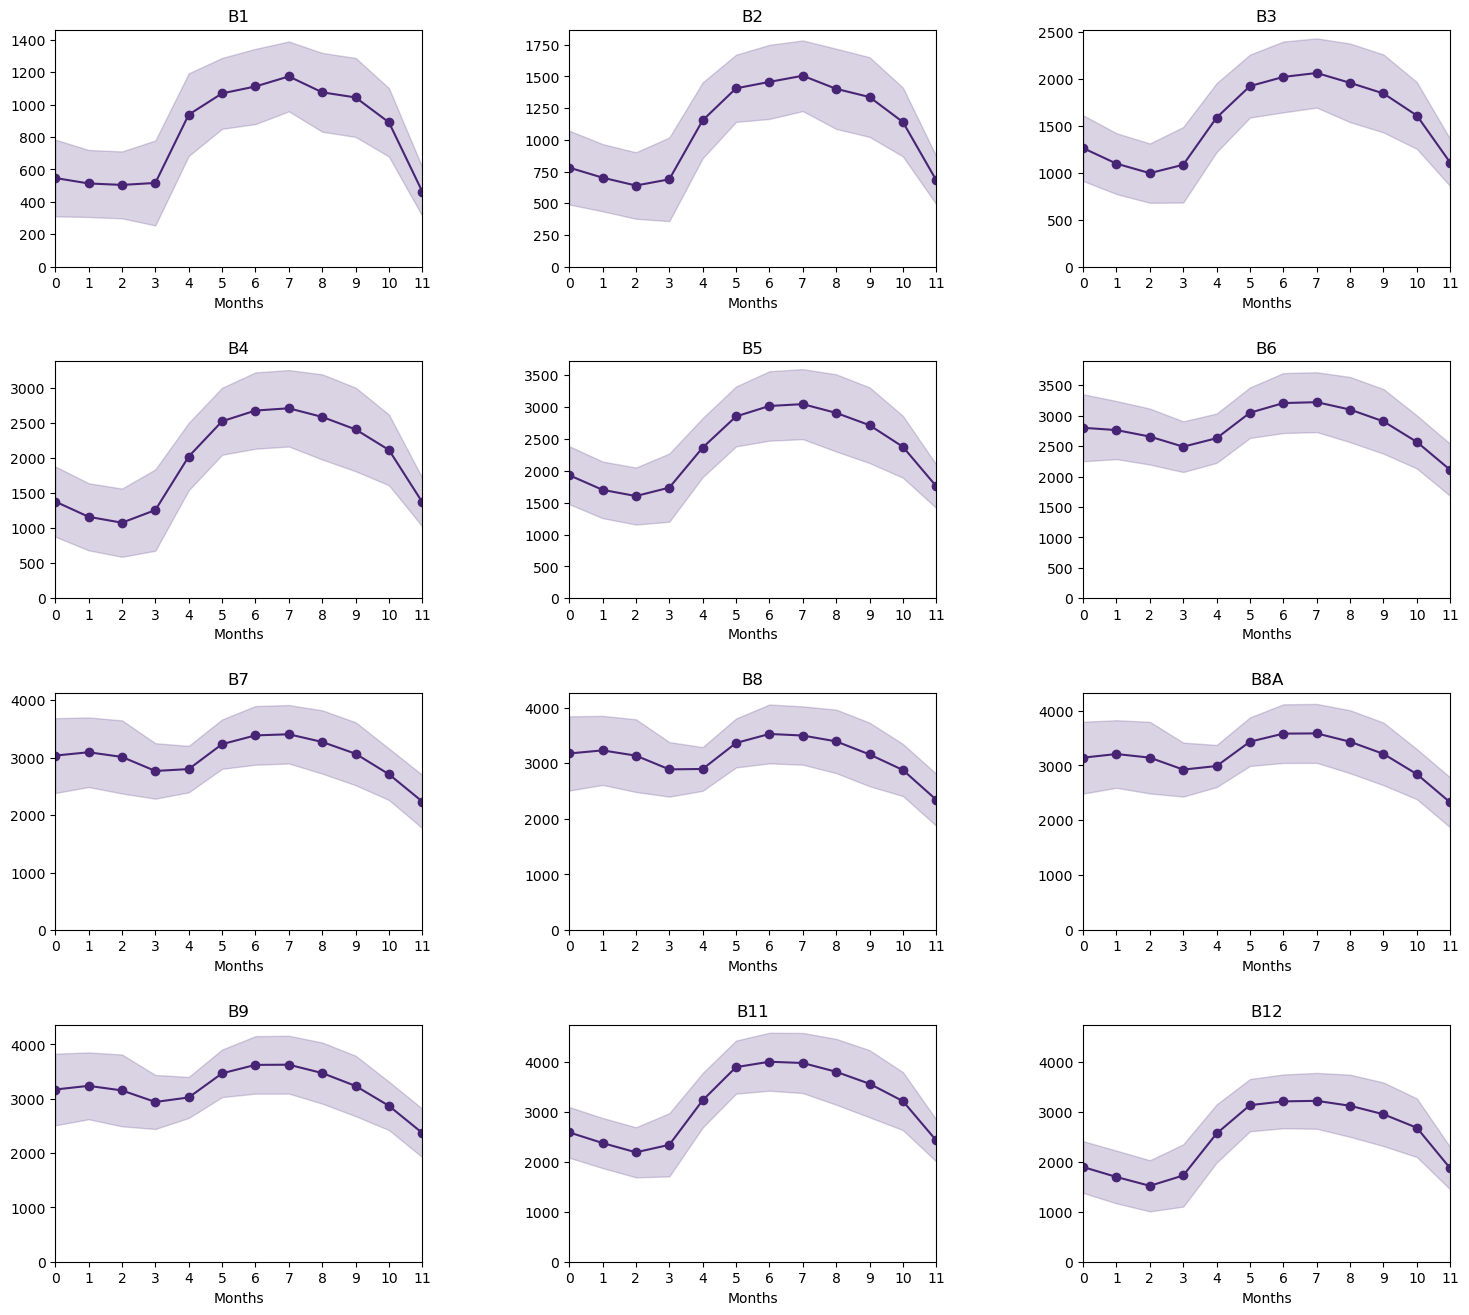

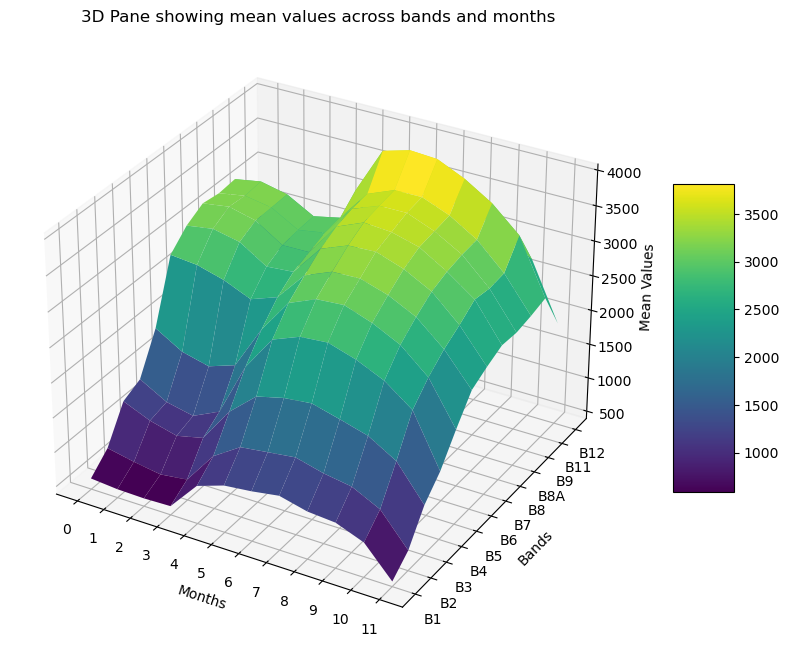

In [74]:
# Display the clusters
create_figs(df2)

In [101]:
# load 2024 
zones = load_zones("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/zones/")   
df1, df2_clear = prep_data("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/data/2019.csv")

In [ ]:
df_overlap = pd.DataFrame()

for zone in zones: 
    df_in, df_out = clip_to_polygon(zone, df1)
    if not df_in.empty:
        df_overlap = pd.concat([df_overlap, df_in], ignore_index=True)

# drop duplicates
df_in = df_overlap.drop_duplicates(subset=["file_name", ".geo"])
df_in.set_index("file_name", inplace=True)

df_out = df1[~df1.index.isin(df_in.index)]

In [104]:
export_to_tif(df_in, ['0_B4', '0_B3', '0_B2'], "_test/df_in_full.tif")

In [103]:
export_to_tif(df_out, ['0_B4', '0_B3', '0_B2'], "_test/df_df_out_full.tif")

# Zone 3 Agricultrual Landscape 

In [ ]:
zone = load_zones("F:/0-Projects/GEE-UNESCO/COMM514_A_12_202425/zones/zone003.geojson")   

[<MULTIPOLYGON (((44.007 34.08, 43.981 34.082, 43.98 34.083, 43.979 34.084, 4...>]

In [109]:
clip_in, clip_out = clip_to_polygon(zone[0], df1)

# summarise the clipped data
df_clip_in_summary = summarise(clip_in)
df_clip_out_summary = summarise(clip_out)

In [113]:
# save tif 
export_to_tif(clip_in, ['0_B4', '0_B3', '0_B2'], "_test/zone003_rgb_in.tif")
export_to_tif(clip_out, ['0_B4', '0_B3', '0_B2'], "_test/zone003_rgb_out.tif")

Clipped In Summary:


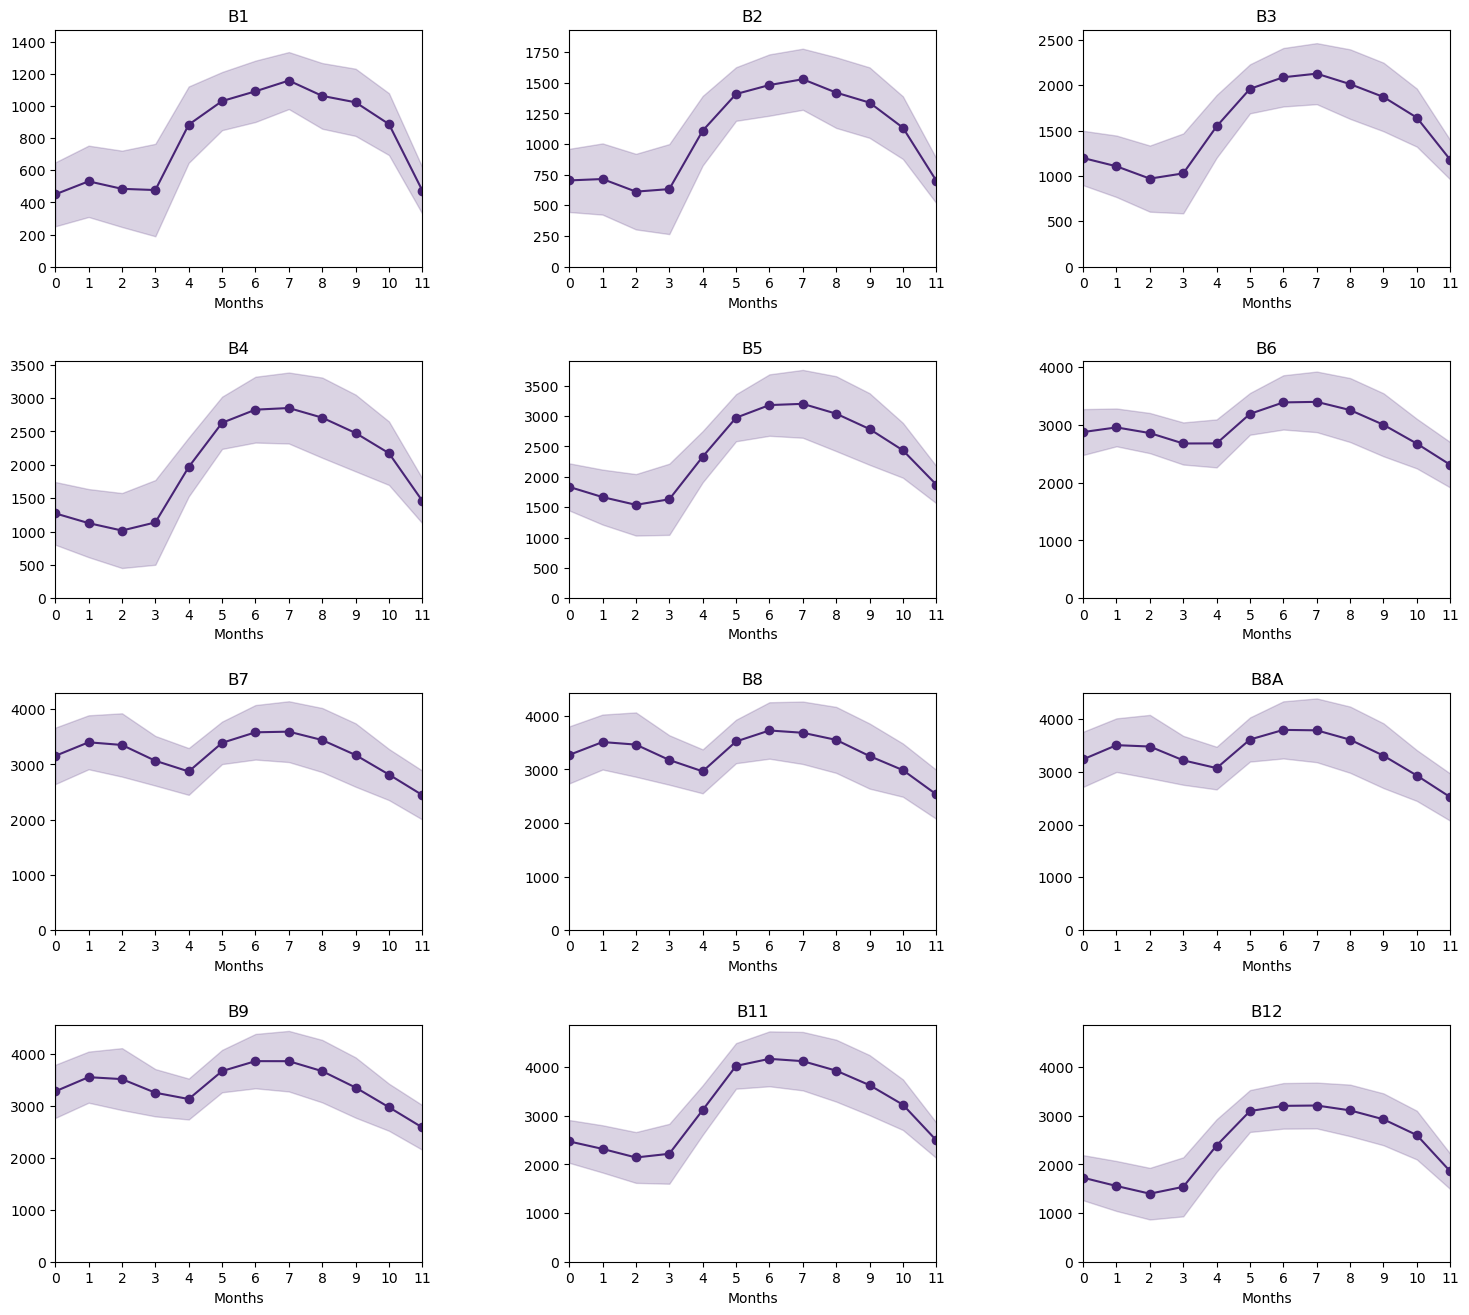

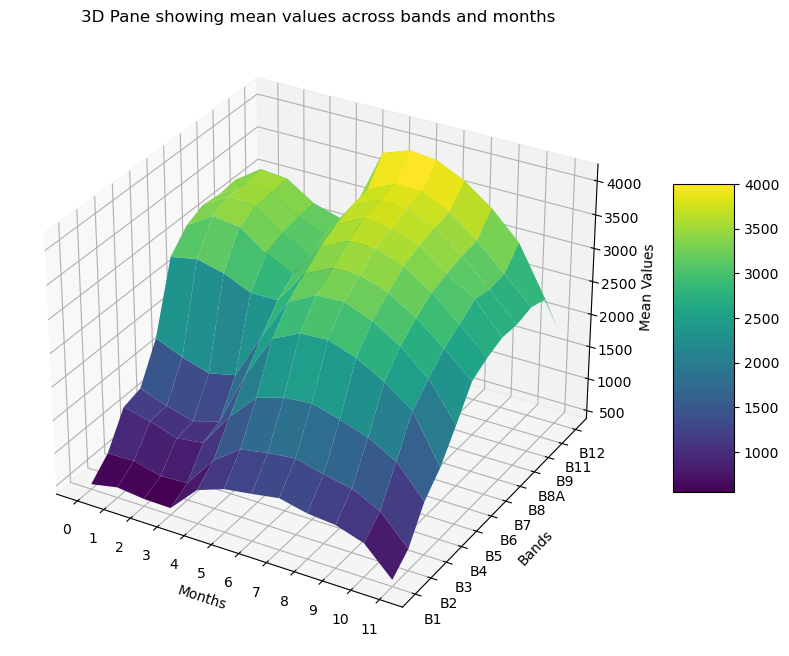

In [110]:
# display the summaries
print("Clipped In Summary:")
create_figs(df_clip_in_summary)

Clipped Out Summary:


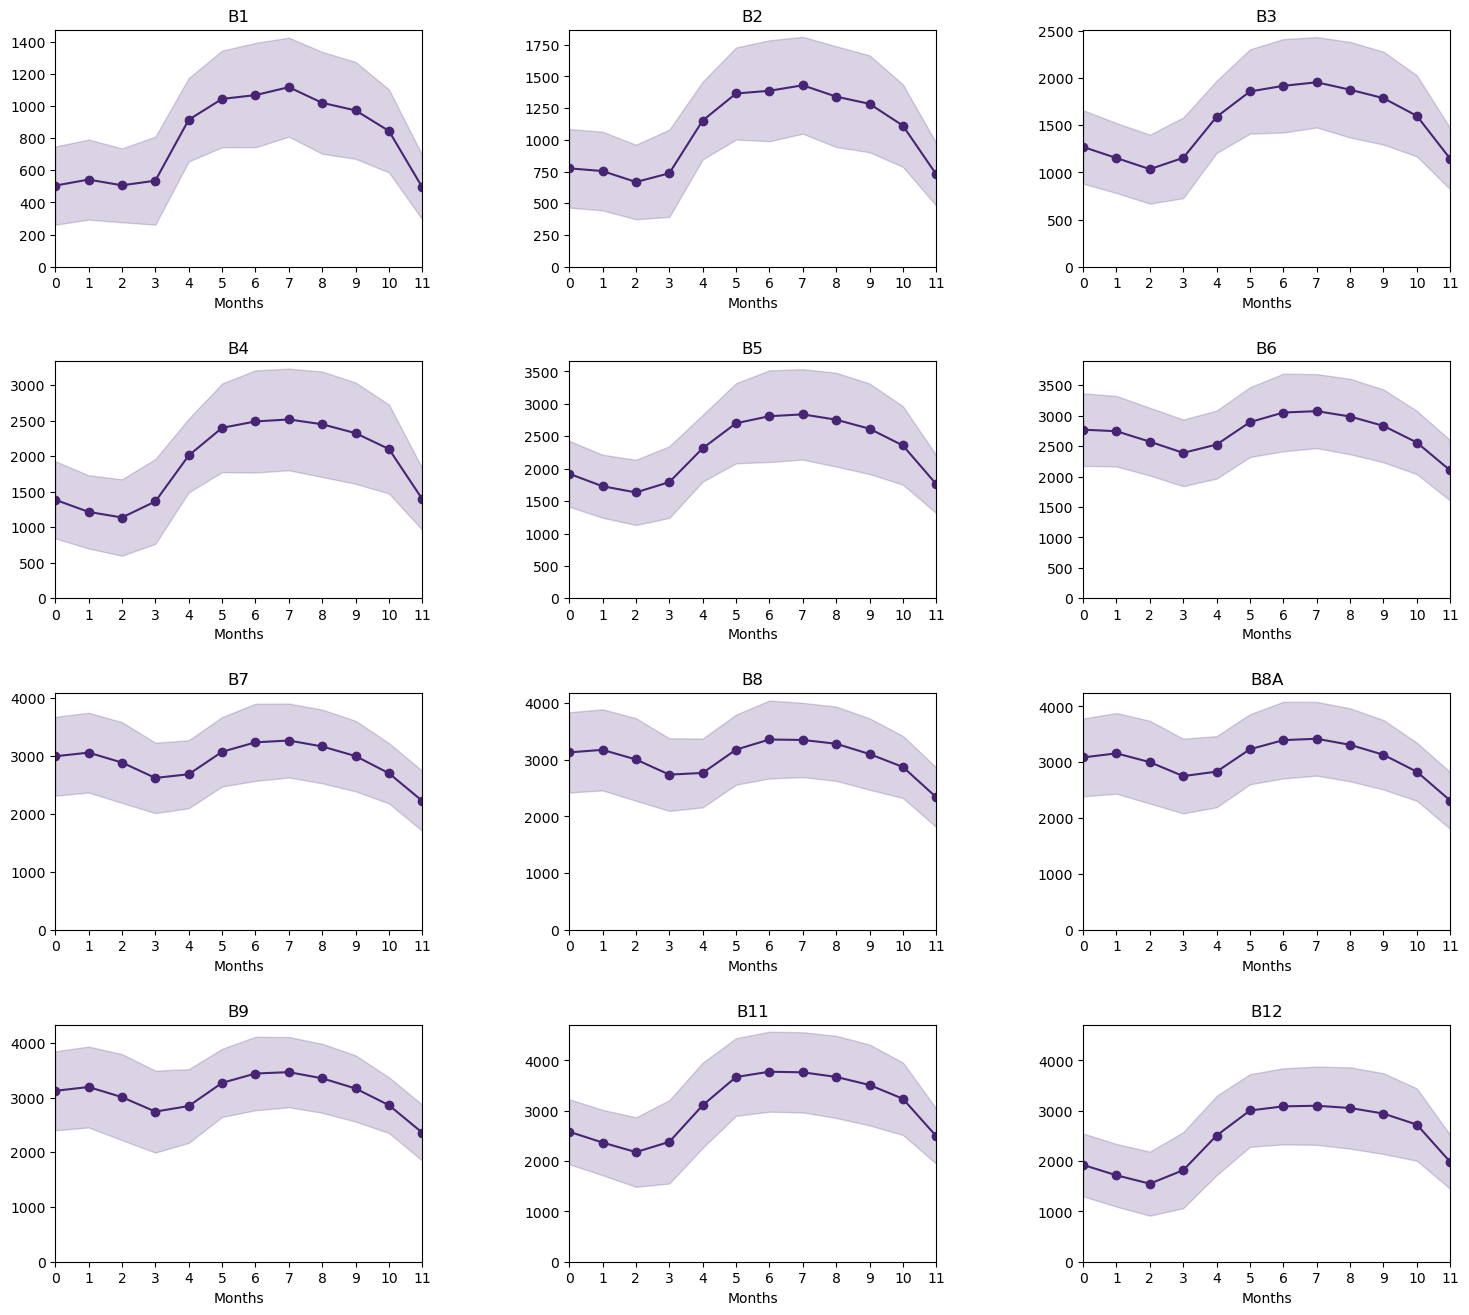

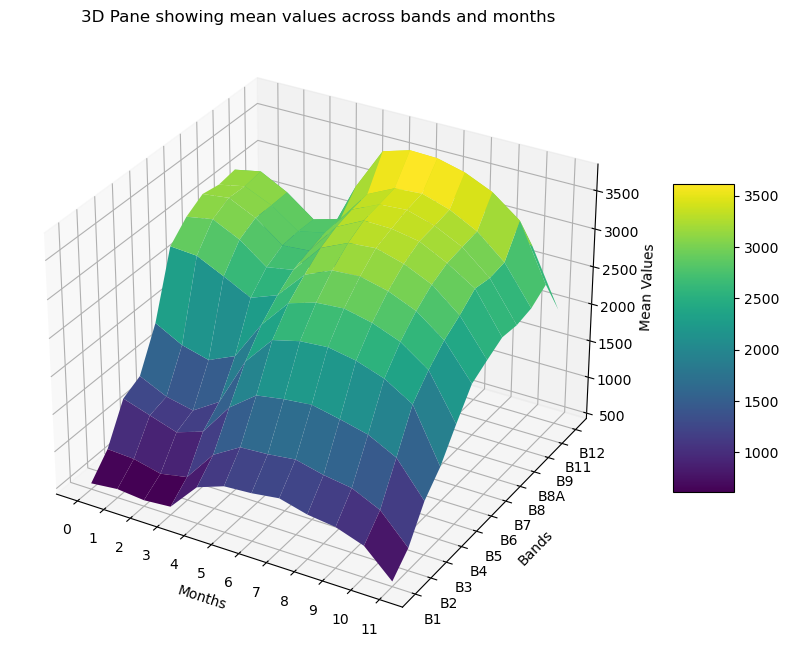

In [112]:
# display the summaries
print("Clipped Out Summary:")
create_figs(df_clip_out_summary)

In [ ]:
# save the files .tif 
